In [1]:
import sys
import regex as re
import numpy as np
import io
import matplotlib.pyplot as plt
import pandas as pd
import math
import h5py
import time
import os
import datetime
import pickle
from scipy.stats import zscore
from scipy.ndimage.filters import gaussian_filter
from scipy.stats import pearsonr
from sklearn.metrics import r2_score

LOCAL = True
BASE_DIR = '../'

if not LOCAL:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    BASE_DIR = '/content/drive/My Drive/Colab Notebooks/thesis/'

sys.path.append(BASE_DIR + 'lib')
sys.path.append(BASE_DIR + 'config')
from preprocessing import process_sakt, save_h5, transpose_list, process_one_feature, select_from_rows, progressBar
import dataset_parameters as params

# DATASET = 'akribian'
# DATASET = 'assistments_2012'
# DATASET = 'junyi_academy'
DATASET = 'ednet'

INPUT_DIR = BASE_DIR + 'data/' + DATASET + '/raw/'
IN_FILE_NAME = 'transformed.csv'
FIGURE_PATH = '../figures/'
BINS = 100

## Load the data

In [2]:
columns = params.columns_dict['generic']
encoding = params.encodings_dict[DATASET]
data = pd.read_csv(INPUT_DIR + IN_FILE_NAME, encoding = encoding)
data

,Unnamed: 0,user_id,category,correctness,exercise_id,elapsed_time,timestamp,elapsed_zscore,elapsed_mean,correctness_mean
0,1,115,6,1,5717,37.0,56.943,0.836764,21.724882,0.735190
1,2,115,2,1,129,55.0,118.363,1.874930,23.471403,0.984092
2,3,115,2,1,7861,19.0,131.167,-0.045952,19.462747,0.954813
3,4,115,2,1,7923,11.0,137.965,-1.208912,20.110520,0.953215
4,5,115,2,1,157,5.0,157.063,-1.207056,18.810512,0.931887
...,...,...,...,...,...,...,...,...,...,...
98878789,101230327,2147482888,6,1,3587,18.0,428564.420,-0.306540,24.781216,0.741063
98878790,101230328,2147482888,6,1,6342,14.0,428585.000,-0.510085,24.827936,0.528547
98878791,101230329,2147482888,6,1,4213,14.0,428613.475,-0.534798,25.972512,0.616541
98878792,101230330,2147482888,6,0,6344,22.0,428649.406,-0.127090,24.741762,0.665904


In [3]:
print("Calculating mean for elapsed time...")
means_elapsed = data.groupby(['exercise_id']).elapsed_time.mean().fillna(0).reset_index()['elapsed_time']
print("Calculating std for elapsed time...")
stds_elapsed = data.groupby(['exercise_id']).elapsed_time.std().fillna(0).reset_index()['elapsed_time']
print("Calculating mean for correctness...")
means_correctness = data.groupby(['exercise_id']).correctness.mean().fillna(0).reset_index()['correctness']
print("Calculating std for correctness...")
stds_correctness = data.groupby(['exercise_id']).correctness.std().fillna(0).reset_index()['correctness']

print("Done!")

Calculating mean for elapsed time...
Calculating std for elapsed time...
Calculating mean for correctness...
Calculating std for correctness...
Done!


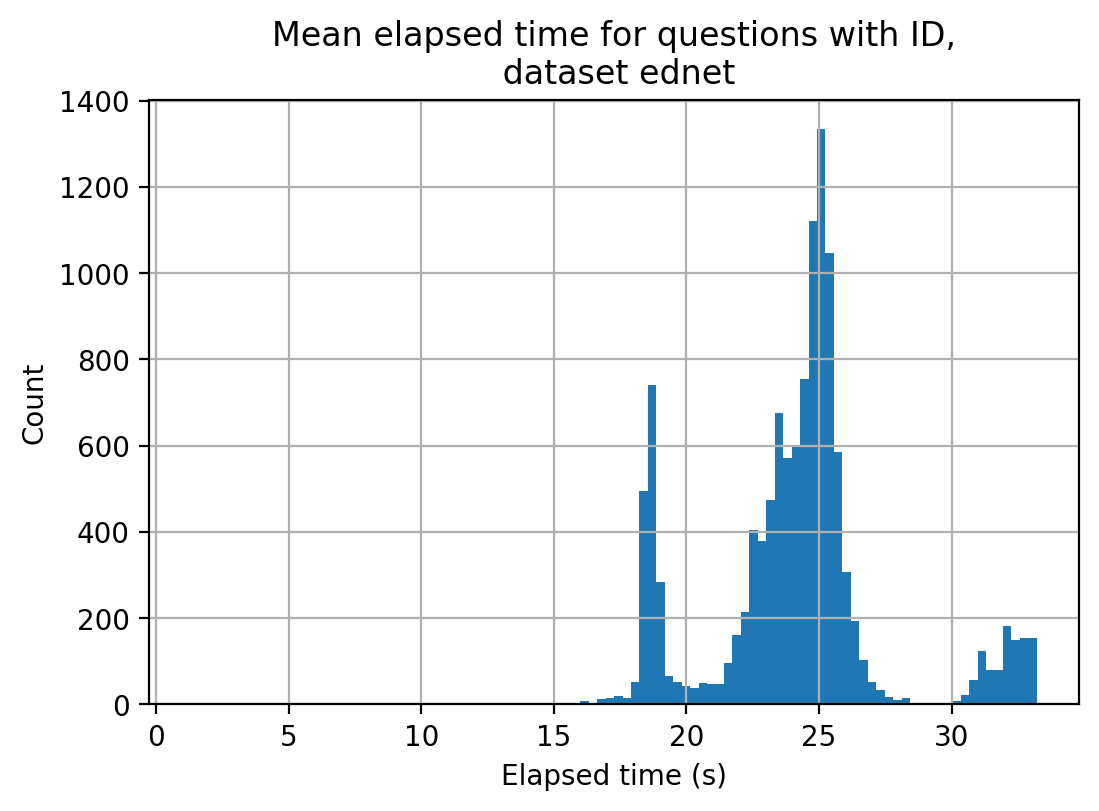

In [4]:
plt.figure(dpi=200)
means_elapsed[means_elapsed < means_elapsed.quantile(0.90)].hist(bins = BINS)
plt.title("Mean elapsed time for questions with ID,\n dataset " + DATASET)
plt.xlabel("Elapsed time (s)")
plt.ylabel("Count")
plt.savefig(FIGURE_PATH + DATASET + "_elapsed_mean.png")

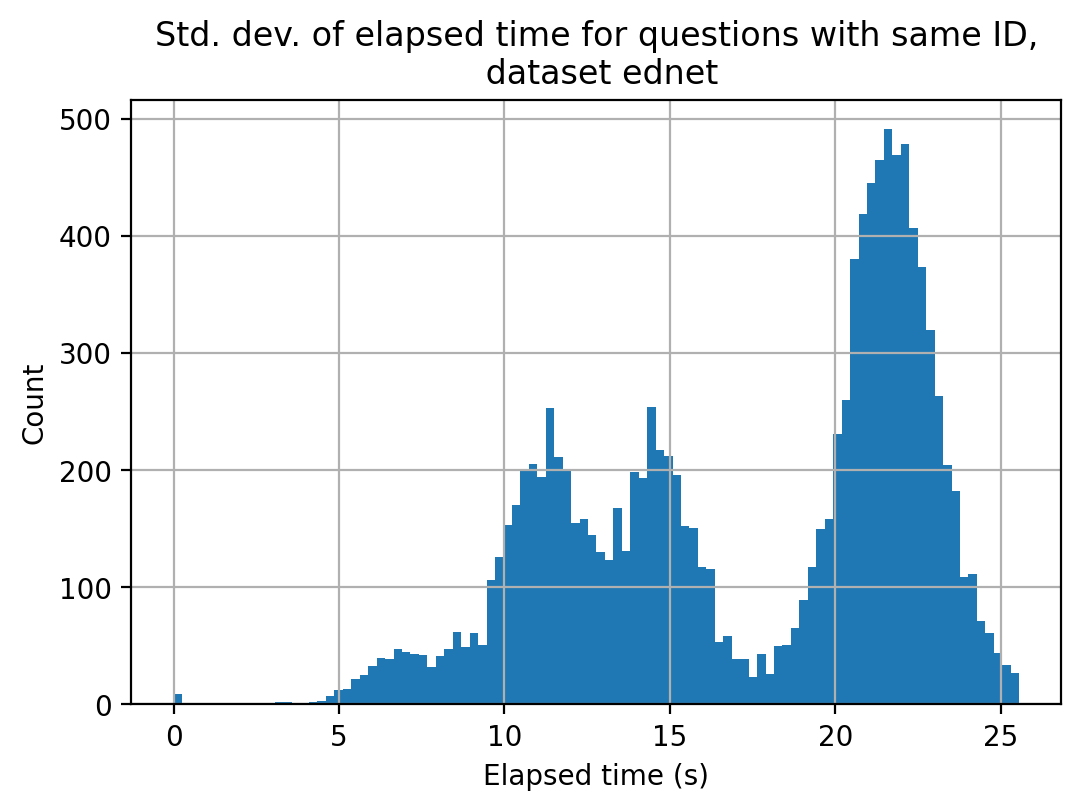

In [5]:
plt.figure(dpi=200)
stds_elapsed[stds_elapsed < stds_elapsed.quantile(0.90)].hist(bins = BINS)
plt.title("Std. dev. of elapsed time for questions with same ID,\n dataset " + DATASET)
plt.xlabel("Elapsed time (s)")
plt.ylabel("Count")
plt.savefig(FIGURE_PATH + DATASET + "_elapsed_std.png")

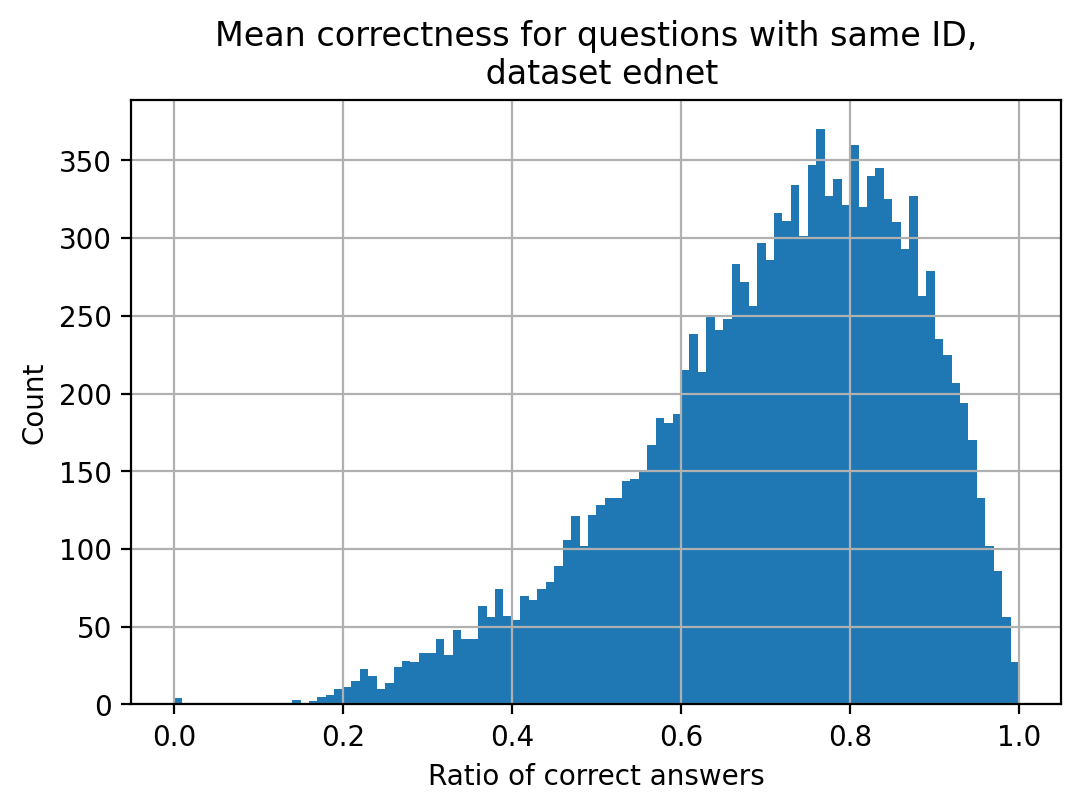

In [6]:
plt.figure(dpi=200)
bins_correctness = np.arange(0,BINS+1)/BINS
means_correctness.hist(bins = bins_correctness)
plt.title("Mean correctness for questions with same ID,\n dataset " + DATASET)
plt.xlabel("Ratio of correct answers")
plt.ylabel("Count")
plt.savefig(FIGURE_PATH + DATASET + "_correct_mean.png")

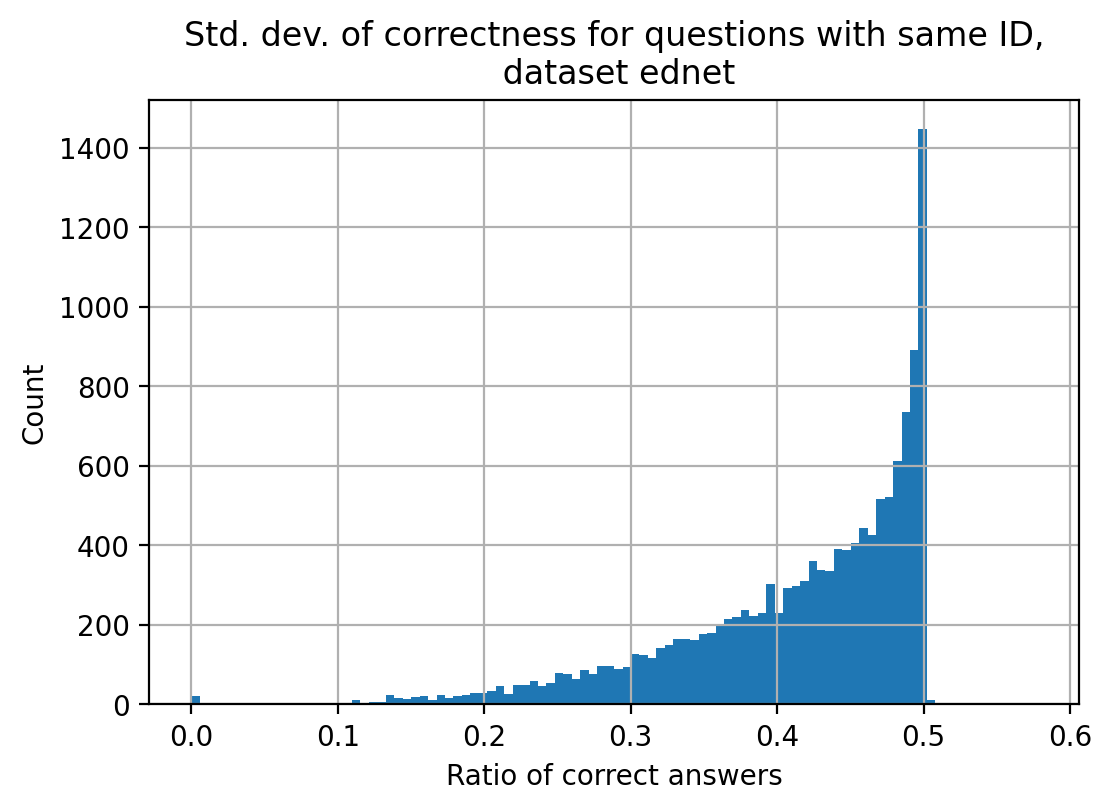

In [7]:
plt.figure(dpi=200)
stds_correctness.hist(bins = BINS)
plt.title("Std. dev. of correctness for questions with same ID,\n dataset " + DATASET)
plt.xlabel("Ratio of correct answers")
plt.ylabel("Count")
plt.savefig(FIGURE_PATH + DATASET + "_correct_std.png")

In [8]:
means = data.groupby(['exercise_id']).elapsed_time.mean().fillna(0).to_frame()
means['correctness'] = data.groupby(['exercise_id']).correctness.mean().fillna(0)
means = means[means['elapsed_time'] < means['elapsed_time'].quantile(0.90)]
means

,elapsed_time,correctness
exercise_id,,
1,21.875328,0.907695
2,22.091626,0.890646
3,23.546322,0.554318
4,23.318762,0.779461
5,23.126772,0.613210
...,...,...
13519,25.489054,0.786866
13520,26.493306,0.571429
13521,24.232519,0.672474


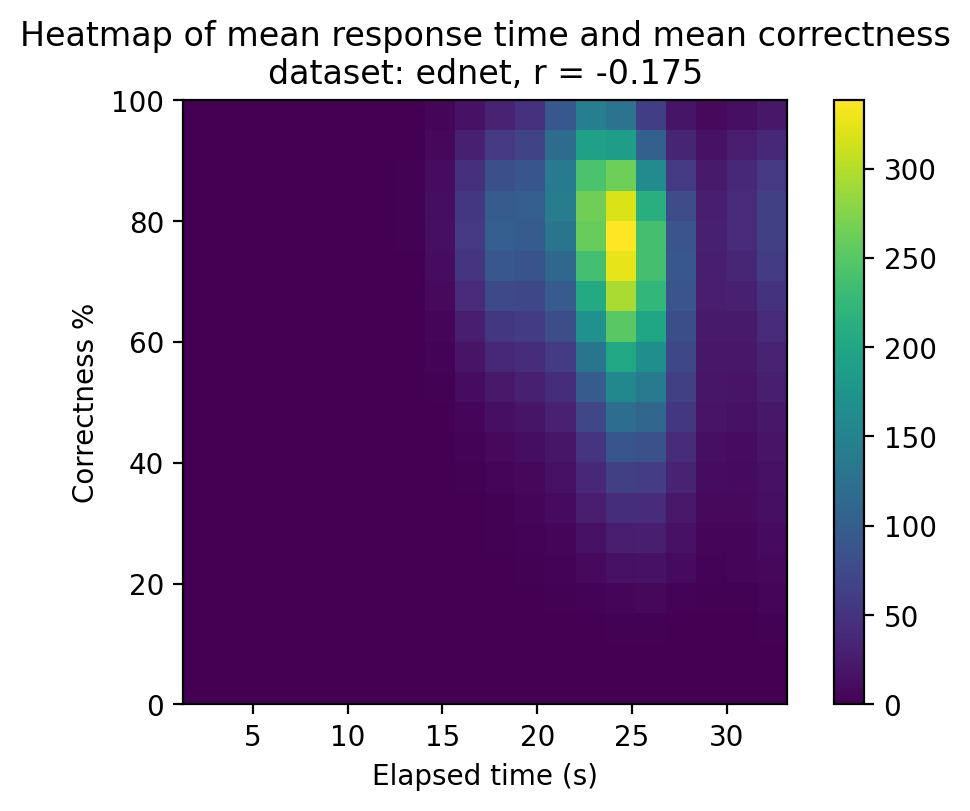

In [9]:
b = 20
heatmap, xedges, yedges = np.histogram2d(means['elapsed_time'], means['correctness']* 100, bins=(b,b))
corr, _ = pearsonr(means['elapsed_time'], means['correctness'])
r2 = r2_score(means['elapsed_time'], means['correctness'])
heatmap = gaussian_filter(heatmap, 1)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
aspect = (xedges[-1] - xedges[0])/(yedges[-1] - yedges[0])
plt.figure(dpi=200)
plt.imshow(heatmap.T, extent=extent, origin='lower', aspect=aspect)
plt.title('Heatmap of mean response time and mean correctness\ndataset: %s, r = %.3f' % (DATASET, corr))
plt.xlabel('Elapsed time (s)')
plt.ylabel('Correctness %')
plt.colorbar()
plt.savefig(FIGURE_PATH + DATASET + "_heat.png")